# Imports


Proj_CIS_Imagens_Raio_X.ipynb

## Install pydicom

In [1]:
# #pydicom trata as imagens em formatos DCM, que é tipo de arquivo das imagens 
# !pip install pydicom

## Import all libraries

In [2]:
# For files e data manipulations
import pandas as pd     
import os                
import zipfile                
import shutil            
import glob  
import gdown            

#For math operations           
import time               
import random               
import math                
import numpy as np 

#For plot
from matplotlib import pyplot     
import matplotlib.pyplot as plt  

#For images operations
import cv2             
import pydicom          
# from google.colab.patches import cv2_imshow    
from PIL import Image     
from numpy import expand_dims  
from scipy.io import loadmat 

#For model  
import tensorflow as tf          
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# import string             
# from tqdm import tqdm     


2022-11-19 21:48:43.033633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 21:48:43.230087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lessinha/X-rayBodyPart/lessinha/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-19 21:48:43.230111: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 21:48:43.277102: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when

Eliminating warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions to downloads

In [4]:
def download(id: str) -> None:      #Download files by link GoogleDrive
    url = 'https://drive.google.com/uc?id=' + str(id)
    gdown.download(url, output = None, quiet = False)

def unzip(path: str) -> None:     #Unzip files .zip
    zip = zipfile.ZipFile(path)
    zip.extractall()
    zip.close()

## Root path

In [5]:
#If running in colab root_path = '/content/'
root_path = ''

In [6]:
# https://drive.google.com/file/d/1ev-r31j8oRzDlKM_toaeADO2psrA_XXm/view?usp=sharing

if os.path.isfile(f'{root_path}archive.zip'):
    print('O arquivo existe.')
    unzip(f'{root_path}archive.zip')    

else:
    download('1ev-r31j8oRzDlKM_toaeADO2psrA_XXm')
    unzip(f'{root_path}archive.zip')    


O arquivo existe.


In [7]:
#leitura dos arquivos originais para obter tanto o dataset de treino quanto o dataset de teste, que servirá de prova real

# os.chdir(f'{root_path}/drive/MyDrive/RAIO-X/RAIO-X/archive.zip (Unzipped Files)")
path = os.getcwd() 
train_df = pd.read_csv(f'{root_path}train.csv')
test_df = pd.read_csv(os.path.join(f'{root_path}sample_submission.csv'))

In [8]:
test_df.head(5)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


# Check pre-processing Data Frame

In [9]:
#Checks Pandas Dataset format and content properties
print("Columns:")
print(train_df.columns, "\n")

print("Types in columns:")
print(train_df.dtypes, "\n")

print("Types in info:")
print(train_df.describe(), "\n")

Columns:
Index(['SOPInstanceUID', 'Target'], dtype='object') 

Types in columns:
SOPInstanceUID    object
Target            object
dtype: object 

Types in info:
                                           SOPInstanceUID Target
count                                                1738   1738
unique                                               1738     41
top     1.2.826.0.1.3680043.8.498.10025629581362719970...     3 
freq                                                    1    724 



## Dictionary Bodyparts

The bodyparts code was taken of kaggle [The UNIFESP X-Ray Body Part](https://www.kaggle.com/datasets/felipekitamura/unifesp-xray-bodypart-classification)

In [10]:
bodyparts = {0 : 'Abdomen', 1 :'Ankle', 2 :'Cervical Spine', 3 : 'Chest', 4 :'Clavicles', 5 :'Elbow',
             6 :'Feet', 7 : 'Finger', 8 : 'Forearm', 9 : 'Hand', 10 : 'Hip',
            11 : 'Knee', 12 : 'Lower Leg', 13 : 'Lumbar Spine', 14 : 'Others', 15 :'Pelvis',
            16 :'Shoulder', 17 :'Sinus', 18 : 'Skull', 19 : 'Thigh', 20 :'Thoracic Spine', 21: 'Wrist'}

## Fixing folders

### Class Image_processing

In [11]:
#Classe de processamento de imagem que mexe com pastas também -começa declarando variaveis de modificação de imagem 
#Class for pre processing files, folders, and images
class Image_processing():
  def __init__(self, folder: str, newFolder: str) -> None:
    self.fileList = []
    self.rotationRange = 90 
    self.brightRange = [0.2, 1.5]
    self.folder = folder                      #This is the folder of the original folder image
    self.newFolder = newFolder                #This is the new folder

  def createfolders(self) -> None:            # Create folders for each label. For example: mkdir("/Finger")
    os.mkdir(f'{root_path}{self.newFolder}/') 
    for bodypart in list(bodyparts.values()):
      if os.path.isdir(f'{root_path}{self.newFolder}/{bodypart}') == False:
        os.mkdir(f'{root_path}{self.newFolder}/{bodypart}')
      else:  
          pass       

  def folderImagebyLabel(self, df: pd.core.frame.DataFrame, dictionary: dict) -> None:    #Put each image in a label folder
    filelist = []
    #walk for all folder of "train/train/train"
    for root, dirs, files in os.walk(f'{root_path}{str(self.folder)}'):
      for file in files:
        filelist.append(os.path.join(root,file))

    for filename in filelist:
      dicom = pydicom.dcmread(filename)       #Read filename (image.dcm)
      img = dicom.pixel_array                 #Transform image in n.array 
      var = filename.split("/")               #Split the string path name
      var = var[-1]                           #Take the name of the image
      row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()  #Search the name in DataFrame. This part [:-6] is to remove -c.dcm of the name
      target = df['Target'].iloc[row[0]]      #Take the label key
      if len(target.strip()) > 2:             #Images with more than one label (Bodyparts) is ignored
        continue
      label = dictionary.get(int(target))     #Search label name by key
      resized_img  = (np.maximum(img,0)/img.max())*255    #It is a important part. This organize and resized image.
      im = resized_img.astype(np.uint8)       #Put in 8 bits format
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))    #Equalizer bright
      clahe_img = clahe.apply(im)
      im = Image.fromarray(clahe_img)
      # im.show()
      im.save(os.path.join(f'{root_path}{self.newFolder}', f'{label}', f'{var[:-6]}.png'))    #Save image in .png

  def allImagesFolder(self, df: pd.core.frame.DataFrame) -> None:   #Separate all images in a folder
    filelist = []
    for root, dirs, files in os.walk(f'{root_path}{str(self.folder)}'):
      for file in files:
        filelist.append(os.path.join(root,file))

    for filename in filelist:
      dicom = pydicom.dcmread(filename)
      img = dicom.pixel_array
      var = filename.split("/")
      var = var[-1]
      row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()
      resized_img  = (np.maximum(img,0)/img.max())*255 
      im = resized_img.astype(np.uint8)
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
      clahe_img = clahe.apply(im)
      im = Image.fromarray(clahe_img)
      im.save(os.path.join(f'{root_path}{self.newFolder}/', f'{var[:-6]}.png'))

    return None
 

#### Implementation

In [12]:
#Organize the test images folder
nameFolderTest = "test_img"
processImageTest = Image_processing(folder='test', newFolder = nameFolderTest)

try:
  os.mkdir(f'{root_path}{nameFolderTest}')
  processImageTest.allImagesFolder(train_df)

except:
  shutil.rmtree(f'{root_path}{nameFolderTest}/')
  os.mkdir(f'{root_path}{nameFolderTest}')
  processImageTest.allImagesFolder(train_df)
print('')

In [13]:
#Organize the train images folder
nameFolderTrain = "train_img"
processImageTrain = Image_processing(folder='train', newFolder = nameFolderTrain)

try:
  processImageTrain.createfolders()
  #This "train" is the name of the original folder of the images
  processImageTrain.folderImagebyLabel(train_df, bodyparts)
except:
  shutil.rmtree(f'{root_path}{nameFolderTrain}/')
  processImageTrain.createfolders()
  processImageTrain.folderImagebyLabel(train_df, bodyparts)


## Data Augumentation

### Class Data_Augumentation

In [14]:
import scipy
#Class for Data Augumentation 
class Data_Augumentation(Image_processing):

  def __init__(self, folder: str, newFolder: str, folder_img: str) -> None:
    super().__init__(folder, newFolder)
    self.folder_img = folder_img
    self.nameImage = []

  def process_imgs(self, qntd: int = 100) -> None: #This method create artificial images by original images
    for folder in os.listdir(f'{root_path}{self.folder_img}'):
      real_qntd = len(os.listdir(f'{root_path}{self.folder_img}/{folder}')) #real_qntd is quantity of exact images
      diff = qntd - real_qntd
      if qntd > real_qntd: 
        if real_qntd >= diff:
          exams = random.choices(os.listdir(f'{root_path}{self.folder_img}/{folder}'), k= diff)   #exams  is a list of images path sorted 
          self.augment(folder, exams, 1)
        else:
          for i in range(100):
            check = real_qntd + real_qntd*i
            if check > qntd: 
              break
            multiplier = i
            diff_mult = qntd - check
          #From each original image we will take x times to approximate the required
          exams = [x for x in os.listdir(f'{root_path}{self.folder_img}/{folder}') if x.find("copy") == -1 ]  
          self.augment(folder, exams, multiplier) #Here we take by lot the rest that escapes the multiple
          
          if diff_mult>0:
            exams = [x for x in os.listdir(f'{root_path}{self.folder_img}/{folder}') if x.find("copy") == -1 ]
            exams = random.choices(exams, k= diff_mult)
            self.augment(folder, exams, 1)
  
  #If you have more original images than requested, we get rid of the excess images by drawing too            
      elif real_qntd > qntd:
        diff = (real_qntd-qntd)
        sorteados = glob.glob(f'{root_path}{self.folder_img}/{folder}/*')
        for s in random.sample(sorteados, diff):
          os.remove(s)


  def augment(self, folder: str, exams: list, limit: int) -> None:
    #folder = name I gave to the label folder (ex: skull)
    #exams = list of image files for each label folder
    #limit = amount of artificial images created from the original
    
    cont1 = -1
    for exam in exams: 
      self.nameImage.append(exam)
      img = load_img(f'{root_path}{self.folder_img}/{folder}/{exam}')
      data = img_to_array(img)
      #Acrescenta uma dimenção no "shape" da imagem referente ao batch - que será tamanho 1, o que não muda nada e serve apenas para rodar a função
      samples = expand_dims(data, 0)
      #Call ImageDataGenerator to change the image, for a new image with rotarion, brightness and flip
      datagen = ImageDataGenerator(
          horizontal_flip=True,
          rotation_range=self.rotationRange,
          brightness_range=self.brightRange
      )
      
      it = datagen.flow(samples, batch_size=1)
      cont1 =+ 1

      dup = [x for i, x in enumerate(self.nameImage) if i != self.nameImage.index(x)]   #This is for duplicates

      #In case of duplicate, it is written in its name that it is a repetition and a case of random duplication
      if len(dup) > 0:
        equalDup = "_repeted_" + str(random.randint(-9999,9999))
      else:
        equalDup = ""
        
      for cont in range(limit):
        batch = it.next()
        image = batch[0].astype('uint16')
        resized_img  = (np.maximum(image,0)/image.max())*255 
        im = Image.fromarray(resized_img.astype(np.uint8))
        rand = random.randint(-9999,9999)
        im.save(f'{root_path}{self.folder_img}/{folder}/{exam[:-4]}_{equalDup}_copy_{cont1}_{cont}.png')

#### Implementation

In [15]:
#Augumented for Train image
AugumentedTrain  =  Data_Augumentation(folder='train', newFolder = nameFolderTrain, folder_img = "train_img")
qntd_for_model = 200
AugumentedTrain.process_imgs(qntd=qntd_for_model) #It is this part that should put the quantities of imagens for the model AugumentedTrain.process_imgs(qntd = XXX)

## Check images in folder

In [16]:
for files in os.listdir(f'{root_path}train_img'):
  print(files)
  print(len(os.listdir(f'{root_path}train_img/{files}')))

Hip
200
Hand
200
Wrist
200
Ankle
200
Chest
200
Sinus
200
Feet
200
Thoracic Spine
200
Pelvis
200
Knee
200
Clavicles
200
Elbow
200
Finger
200
Abdomen
200
Thigh
200
Shoulder
200
Skull
200
Cervical Spine
200
Others
200
Lower Leg
200
Lumbar Spine
200
Forearm
200


## Select Folders for model

### Class Select_Folders

In [17]:
class Select_Folders(): #This folder check with have the quantities is right and put images of apropriate folder
  def __init__(self, root: str, qntd: int, mainPath: str ='') -> None:
    self.mainPath = mainPath
    self.qntdImages = qntd
    self.listNames = []
    self.flag = []
    self.rootPath = root
  

  def verify(self, folder2verify, order):   #Verify with folder have the right the amount of images 
    for files in os.listdir(folder2verify):
      self.listNames.append([files, len(os.listdir(f'{folder2verify}/{files}')) ])

    for i in self.listNames:
      if i[1] > self.qntdImages:
      #False if you have folders with less than 100 images or less than self.qntdImages
      #The flag list stores the value of phalluses, then the name of the label folder and the number of images in it
        self.flag.append([False, i[0], i[1]])

    if order == "print":
      print(self.flag)
    if order =="result":
      flagzinha = False
      
      for i in zip(self.flag): 
        if i[0] == True:
          print(f"Error: The folder {i[1]} has {i[2]} Images.")
        else:
          flagzinha = True

      if flagzinha == False:
        print(f"Every folder has more than {self.qntdImages} Images.")

  def trainFolder(self, path, qntd , bodyparts): 
    '''
    Create folder for the model with specific amount of images (qntd)
    '''
    try:
      os.mkdir(f"{self.rootPath}{path}")
      # print(self.rootPath)      # print(path)
    except:
      shutil.rmtree(f"{self.rootPath}{path}")
      os.mkdir(f"{self.rootPath}{path}")

    #For each label in text format it is checked if a folder already exists
    for part in list(bodyparts.values()):
      if os.path.isdir(f"{self.rootPath}{path}/{part}") == False:
        os.mkdir(f"{self.rootPath}{path}/{part}")
      #Select 'x' images from a label folder and copy it to imageModel  
      # selectImages = random.choices(os.listdir(f'{self.mainPath}/{part}'), k= qntd)
      selectImages = os.listdir(f'{self.mainPath}/{part}')
      # print(f'{len(selectImages[:qntd])}')
      
      for image in selectImages[:qntd]:
        pathImageModel = f"{self.rootPath}{path}/{part}/{image}"
        originalPathImages = f'{self.mainPath}/{part}/{image}'
        # print(originalPathImages)
        # print(pathImageModel)
        shutil.copy(originalPathImages, pathImageModel)
  def validationFolder(self, path, qntd , bodyparts, qntd_train): 
    try:
      os.mkdir(f"{self.rootPath}{path}")
      # print(self.rootPath)      # print(path)
    except:
      shutil.rmtree(f"{self.rootPath}{path}")
      os.mkdir(f"{self.rootPath}{path}")

    #For each label in text format it is checked if a folder already exists
    for part in list(bodyparts.values()):
      if os.path.isdir(f"{self.rootPath}{path}/{part}") == False:
        os.mkdir(f"{self.rootPath}{path}/{part}")
        
      selectImages = os.listdir(f'{self.mainPath}/{part}')
      # print(f'{len(selectImages[qntd_train:])}')
      
      for image in selectImages[qntd_train:]:
        pathImageModel = f"{self.rootPath}{path}/{part}/{image}"
        originalPathImages = f'{self.mainPath}/{part}/{image}'
        # print(originalPathImages)
        # print(pathImageModel)
        shutil.copy(originalPathImages, pathImageModel)


In [18]:
for files in os.listdir(f'{root_path}train_img'):
  x = len(os.listdir(f'{root_path}train_img/{files}'))
  if x != qntd_for_model:
    print('Some folder has less than 100 images')

#### Checking class functionality

In [19]:
qntd_images = 60

fix_model = Select_Folders(mainPath = f'{root_path}train_img', root = f'{root_path}', qntd = qntd_images)

path = "train_model"
#Organizing the folder for the train_model
# 60 images of 100 for train
fix_model.trainFolder(path, qntd_images, bodyparts)
fix_model.verify(f'{root_path}train_model/' ,'result')

Every folder has more than 60 Images.


In [20]:
qntd_images_val = 40

# fix_model = Select_Folders(mainPath = f'{root_path}/train_img", root = '/content', qntd = qntd_images_val)
fix_model = Select_Folders(mainPath = f'{root_path}train_img', root = f'{root_path}', qntd = qntd_images_val)


path = "val_model"
#Organizing the folder for the val_model
# 40 images of 100 for train
fix_model.validationFolder(path, qntd_images_val, bodyparts, qntd_train = qntd_images)
fix_model.verify(f'{root_path}val_model/', 'result')

#### Implementation

In [21]:
fix2 = Select_Folders(mainPath = f'{root_path}/train_img', root = f'{root_path}' , qntd = qntd_for_model)
#Verify if train_img has more than 100 images 
fix2.verify( f'{root_path}train_img' ,"result")

Every folder has more than 200 Images.


# Model

In [23]:
#Select size
batch_size = 32  
img_height = 180 
img_width = 180

train_dir = f'{root_path}train_model'
val_dir = f'{root_path}val_model'

In [24]:
# Build a tensorflow dataset to be placed in the Keras library model
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2, #Part destined for a validation dataset
  subset="training",
  seed=123, 
  image_size=(img_height, img_width), #"shape" of file
  batch_size=batch_size)


Found 1320 files belonging to 22 classes.
Using 1056 files for training.


2022-11-19 21:56:31.068421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lessinha/X-rayBodyPart/lessinha/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-19 21:56:31.069594: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 21:56:31.069755: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-T36DJFM): /proc/driver/nvidia/version does not exist
2022-11-19 21:56:31.077505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# Build a tensorflow dataset to be placed in the Keras library model
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3080 files belonging to 22 classes.
Using 616 files for validation.


In [26]:
# for files in os.listdir(f'{root_path}train_img'):
#   print(files)
#   print(len(os.listdir(f'{root_path}train_img/{files}')))

## Extra

In [27]:
class_names = train_ds.class_names
#print(class_names)

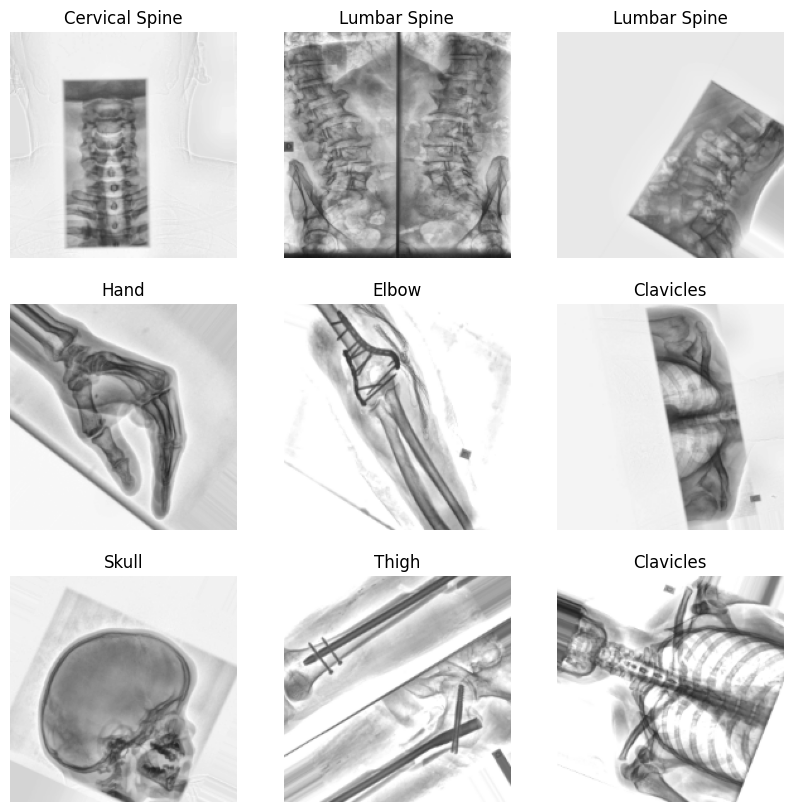

In [28]:
import matplotlib.pyplot as plt

#print first images (first batch) of the generator
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
#Checking "shape" - or format
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [30]:
#Checking "shape" - or format
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Implementing Model

In [31]:
import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
# from tensorflow.keras.applications.inception_v3 import InceptionV3

Transfer Learning choosen

In [32]:
from tensorflow.keras.applications import vgg16

In [33]:
#This function belongs to Matheus Vieira, current IEEE-CIS Project Director
def plot_history(history: keras.callbacks.History) -> None:
  #Show model loss and accuracy while training 
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Random Seed

In [34]:
import random
random.seed(23)

In [35]:
# vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(input_shape = (img_width, img_height, 3), 
                       include_top = False, 
                       weights = 'imagenet')

# vgg.summary()
# Layer of transfer learning not trainable
# vgg.trainable = False
for layer in vgg.layers:
  layer.trainable = False
  
output = vgg.output
# three hidden layers
# output = keras.layers.GlobalAveragePooling2D()(output)
output = keras.layers.Flatten()(output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dropout(0.75)(output) 
output = BatchNormalization()(output)
output = keras.layers.Dropout(0.5)(output) 
# output = keras.layers.Dense(22, activation='relu')(output)
# final softmax layer

predictions = keras.layers.Dense(len(bodyparts), activation='softmax')(output)

# creating the full model:
full_model = keras.models.Model(inputs=vgg.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [36]:
full_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [37]:
! mkdir model

In [38]:
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'model/model_vgg_{qntd_for_model}_1.h5', 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

# Early stop
early_stop = tf.keras.callbacks.EarlyStopping(patience = 4) 


In [39]:
history = full_model.fit(train_ds, 
                        epochs=50,
                        validation_data=val_ds,
                        workers=5,
                        callbacks = [checkpoint, early_stop])

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 4.2267 - accuracy: 0.0777
Epoch 1: saving model to model/model_vgg_200_1.h5
33/33 [==============================] - 252s 8s/step - loss: 4.2267 - accuracy: 0.0777 - val_loss: 2.4936 - val_accuracy: 0.2760
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 3.4198 - accuracy: 0.1629
Epoch 2: saving model to model/model_vgg_200_1.h5
33/33 [==============================] - 233s 7s/step - loss: 3.4198 - accuracy: 0.1629 - val_loss: 1.9490 - val_accuracy: 0.4692
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 2.9744 - accuracy: 0.2055
Epoch 3: saving model to model/model_vgg_200_1.h5
33/33 [==============================] - 235s 7s/step - loss: 2.9744 - accuracy: 0.2055 - val_loss: 1.7055 - val_accuracy: 0.5893
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 2.4725 - accuracy: 0.2936
Epoch 4: saving model to model/model_vgg_200_1.h5
33/33 [===========================

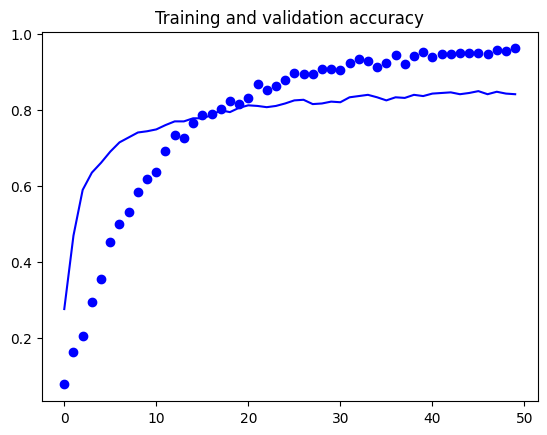

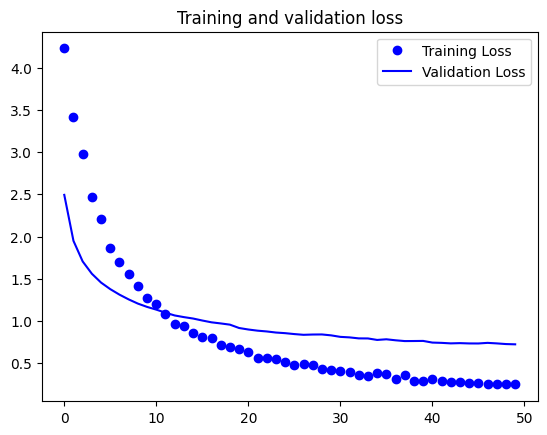

In [40]:
plot_history(history)

In [44]:
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
plot_model(full_model, show_shapes=True, show_layer_names=True, to_file=f"model_vgg_{qntd_for_model}_1.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
